<a href="https://colab.research.google.com/github/stevengregori92/Implementation-of-Learning-KNN-part-3/blob/main/Train_with_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [3]:
!gdown https://drive.google.com/uc?id=1afNS70irJiK_5I_ow47pdBl4Kfs9bBBQ

Downloading...
From: https://drive.google.com/uc?id=1afNS70irJiK_5I_ow47pdBl4Kfs9bBBQ
To: /content/Cancer.zip
100% 49.8k/49.8k [00:00<00:00, 59.8MB/s]


In [4]:
!unzip /content/Cancer.zip

Archive:  /content/Cancer.zip
replace breast-cancer.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
df = pd.read_csv('breast-cancer.csv', index_col='id')
pd.options.display.max_columns=50
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [6]:
df.radius_mean.sort_values(ascending=False)

id
8810703      28.110
911296202    27.420
873592       27.220
899987       25.730
8611555      25.220
              ...  
85713702      8.196
92751         7.760
921092        7.729
921362        7.691
862722        6.981
Name: radius_mean, Length: 569, dtype: float64

#Cleaning Dataset

In [7]:
df.diagnosis = df.diagnosis.replace(['B', 'M'], [0,1])

#Dataset Splitting

In [8]:
X = df.drop(columns=['diagnosis'])
y = df.diagnosis

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

#Data Preprocessing

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'robust'), X_train.columns)
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv = 3, n_jobs=-1, verbose =1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
{'algo__n_neighbors': 3, 'algo__p': 2, 'algo__weights': 'uniform'}
0.9824175824175824 0.9670326478447775 0.9473684210526315


#Feature Importance

,feature,importance,stdev
13,area_se,1.186813e-02,0.005663
21,texture_worst,6.153846e-03,0.003781
28,symmetry_worst,3.956044e-03,0.002563
17,concave points_se,3.956044e-03,0.001645
10,radius_se,3.956044e-03,0.003781
12,perimeter_se,3.516484e-03,0.001758
19,fractal_dimension_se,3.516484e-03,0.002981
18,symmetry_se,3.516484e-03,0.002981
29,fractal_dimension_worst,3.076923e-03,0.002981
4,smoothness_mean,3.076923e-03,0.002241


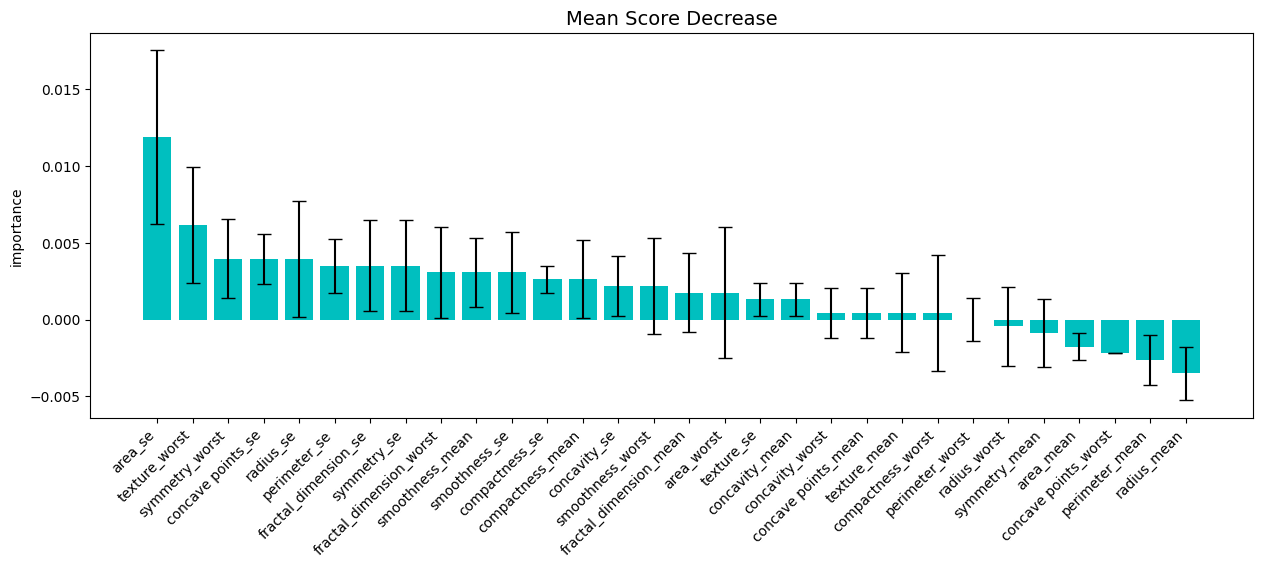

In [11]:
mean_score_decrease(X_train, y_train, model, plot=True, topk=50)

In [12]:
import seaborn as sns

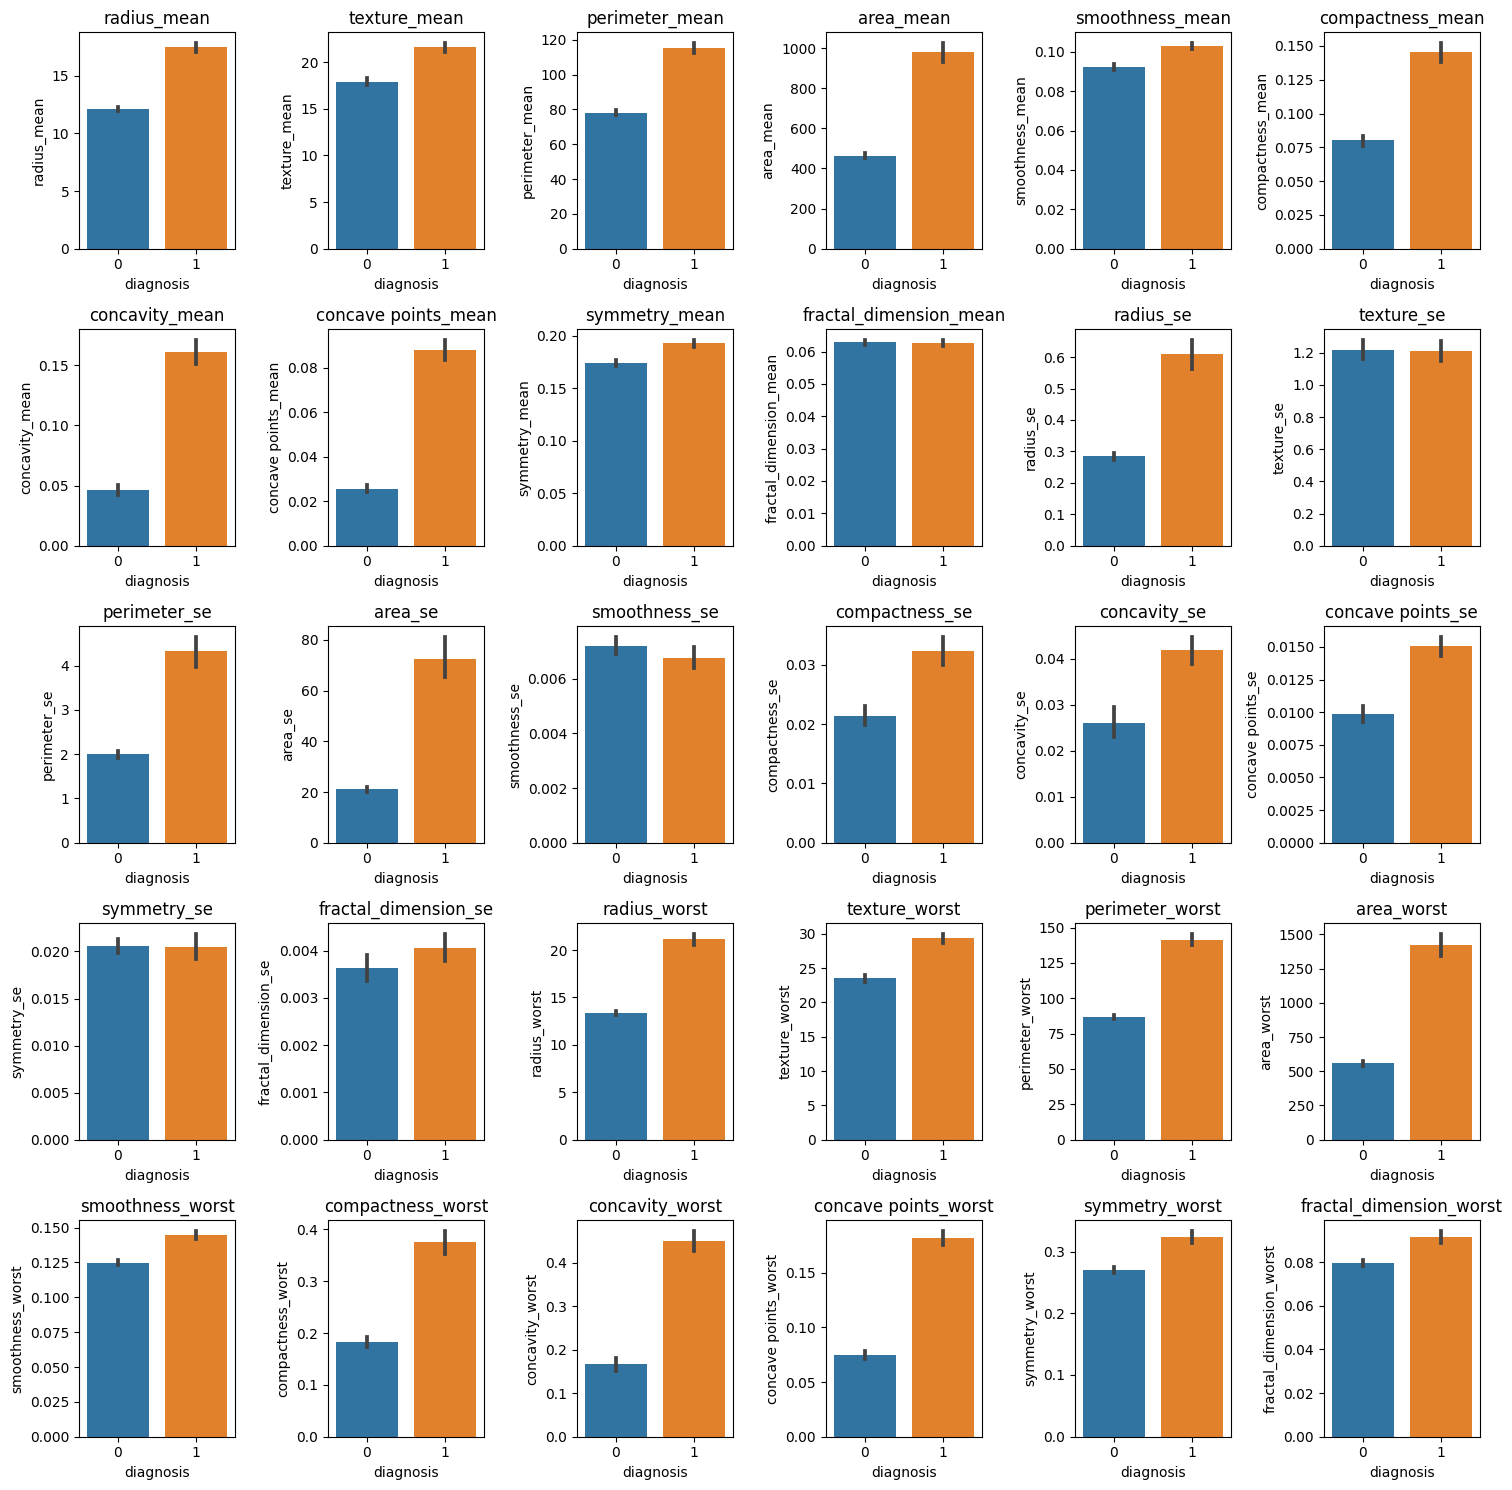

In [13]:
fig, axes = plt.subplots(5, 6, figsize=(15, 15))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the columns and create a bar plot for each column
for i, col in enumerate(df.columns[1:31]):
    ax = axes[i]  # Get the current axis
    sns.barplot(x='diagnosis', y=col, data=df, ax=ax)  # Create the bar plot
    ax.set_title(col)  # Set the title for the subplot

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'robust'), ['area_se', 'texture_worst', 'symmetry_worst', 'concave points_se',
                                                'radius_se', 'perimeter_se', 'fractal_dimension_se', 'symmetry_se',
                                                'fractal_dimension_worst', 'smoothness_mean', 'smoothness_se',
                                                'compactness_se', 'compactness_mean', 'concavity_se',
                                                'smoothness_worst', 'fractal_dimension_mean', 'area_worst',
                                                'texture_se', 'concavity_mean'])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv = 3, n_jobs=-1, verbose =1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__weights': 'uniform'}
0.9714285714285714 0.9626176368072499 0.9210526315789473


#Feature Engineering

In [15]:
df.area_mean.sort_values(ascending=False)

id
911296202    2501.0
8810703      2499.0
873592       2250.0
899987       2010.0
8611555      1878.0
              ...  
85713702      201.9
92751         181.0
921092        178.8
921362        170.4
862722        143.5
Name: area_mean, Length: 569, dtype: float64

In [16]:
df.texture_worst.sort_values(ascending=False)

id
88725602    49.54
88995002    47.16
88119002    45.41
88330202    44.87
925622      42.79
            ...  
912600      14.20
868999      14.10
893988      12.87
8610629     12.49
87127       12.02
Name: texture_worst, Length: 569, dtype: float64

In [17]:
df.area_mean = pd.cut(df.area_mean, [0,250,500,3000], labels=['low', 'medium', 'high'])
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,high,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,high,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,high,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,medium,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,high,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,1,21.56,22.39,142.00,high,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,1,20.13,28.25,131.20,high,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,1,16.60,28.08,108.30,high,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [18]:
df.texture_worst = pd.cut(df.texture_worst, [0,10,20,25,100], labels=['low', 'medium', 'high', 'extreme'])
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,high,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,medium,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,high,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,high,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,high,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,extreme,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,medium,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,extreme,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,high,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,medium,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,1,21.56,22.39,142.00,high,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,extreme,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,1,20.13,28.25,131.20,high,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,extreme,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,1,16.60,28.08,108.30,high,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,extreme,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [19]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'robust'), ['symmetry_worst', 'concave points_se',
                                                'radius_se', 'perimeter_se', 'fractal_dimension_se', 'symmetry_se',
                                                'fractal_dimension_worst', 'smoothness_mean', 'smoothness_se',
                                                'compactness_se', 'compactness_mean', 'concavity_se',
                                                'smoothness_worst', 'fractal_dimension_mean', 'area_worst',
                                                'texture_se', 'concavity_mean']),
    ('categoric', cat_pipe(encoder='onehot'), ['texture_worst', 'area_mean'])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv = 3, n_jobs=-1, verbose =1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__weights': 'uniform'}
0.9560439560439561 0.9472231904263971 0.9298245614035088


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/di